In [1]:
!pip install psycopg2


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install openpyxl


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import psycopg2
import pandas as pd
import psycopg2.extras

In [16]:
class PostgresConnection(object):
    def __init__(self):
        self.connection = psycopg2.connect(database="postgres",
                                          user= "postgres",
                                          password= "cse512",
                                          host="localhost",
                                          port="5432")
    def getConnection(self):
        print("Successfully connected to the database")
        return self.connection

In [17]:
con = PostgresConnection().getConnection()

Successfully connected to the database


<font color= "blue"> <h3> Loading Tables in star schema

In [18]:
trans_dim= pd.read_excel(r'C:\Users\Hp\Downloads\e-commerece_data.xlsx', sheet_name='Trans_dim', engine= 'openpyxl' )

In [19]:
Item_dim= pd.read_excel(r'C:\Users\Hp\Downloads\e-commerece_data.xlsx', sheet_name='Item_dim', engine= 'openpyxl' )

In [20]:
Coustomer_dim= pd.read_excel(r'C:\Users\Hp\Downloads\e-commerece_data.xlsx', sheet_name='Coustomer_dim', engine= 'openpyxl' )

In [21]:
Time_dim= pd.read_excel(r'C:\Users\Hp\Downloads\e-commerece_data.xlsx', sheet_name='Time_dim', engine= 'openpyxl' )

In [22]:
Store_dim= pd.read_excel(r'C:\Users\Hp\Downloads\e-commerece_data.xlsx', sheet_name='Store_dim', engine= 'openpyxl' )

In [23]:
Fact_table= pd.read_excel(r'C:\Users\Hp\Downloads\e-commerece_data.xlsx', sheet_name='Fact_table', engine= 'openpyxl' )

<font color= "blue"> <h3> INSERTING </h3> </font> <br> <font color= "orange"> NOTE: Running this twice will show error!!

In [ ]:
con = PostgresConnection().getConnection()

insert_statement= '''INSERT INTO ecomdb.trans_dim(payment_key, trans_type, bank_name) VALUES(%s, %s, %s)'''

cur= con.cursor()
psycopg2.extras.execute_batch(cur,insert_statement, trans_dim.values)
con.commit()
cur.close()

In [ ]:
con = PostgresConnection().getConnection()

insert_statement= '''INSERT INTO ecomdb.item_dim(item_key, item_name, description, unit_price, man_country, supplier, unit) VALUES (%s, %s, %s, %s, %s, %s, %s)'''

cur= con.cursor()
psycopg2.extras.execute_batch(cur,insert_statement, Item_dim.values, page_size=1000) 
con.commit()
cur.close()

In [ ]:
con = PostgresConnection().getConnection()

insert_statement= '''INSERT INTO ecomdb.coustomer_dim(coustomer_key, name, contact_no, nid)VALUES (%s, %s, %s, %s)'''

cur= con.cursor()
psycopg2.extras.execute_batch(cur,insert_statement, Coustomer_dim.values)
con.commit()
cur.close()

In [24]:
Time_dim['date'] = pd.to_datetime(Time_dim['date'])

In [ ]:
con = PostgresConnection().getConnection()

insert_statement= '''INSERT INTO ecomdb.time_dim(time_key, date, hour, day, week, month, quarter, year)VALUES (%s, %s, %s, %s, %s, %s, %s, %s)'''

cur= con.cursor()
psycopg2.extras.execute_batch(cur,insert_statement, Time_dim.values)
con.commit()
cur.close()

In [ ]:
con = PostgresConnection().getConnection()

insert_statement= '''INSERT INTO ecomdb.store_dim( store_key, division, district, upazila) VALUES (%s, %s, %s, %s)'''

cur= con.cursor()
psycopg2.extras.execute_batch(cur,insert_statement, Store_dim.values)
con.commit()
cur.close()

In [ ]:
con = PostgresConnection().getConnection()

insert_statement= '''INSERT INTO ecomdb.fact_table(payment_key, coustomer_key, time_key, item_key, store_key, quantity, unit, unit_price, total_price)VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)'''

cur= con.cursor()
psycopg2.extras.execute_batch(cur,insert_statement, Fact_table.values)
con.commit()
cur.close()

<font color= "blue"> <h3> Queries

In [25]:
 
con = PostgresConnection().getConnection()

query_statement= '''SELECT s.division, SUM(CAST(t.total_price AS DECIMAL))
FROM ecomdb.fact_table t
JOIN ecomdb.store_dim s on s.store_key=t.store_key
JOIN ecomdb.time_dim tim on tim.time_key=t.time_key
WHERE tim.month=12
GROUP BY s.division
ORDER BY s.division'''

cur = con.cursor()
cur.execute("BEGIN")
cur.execute(query_statement)
# fetch the results
records = cur.fetchall()
# commit the transaction
cur.execute("COMMIT")
# close the cursor
cur.close()
print(records)

Successfully connected to the database
[('BARISAL', Decimal('638101.00')), ('CHITTAGONG', Decimal('1665138.00')), ('DHAKA', Decimal('3440676.25')), ('KHULNA', Decimal('952049.75')), ('RAJSHAHI', Decimal('1041201.25')), ('RANGPUR', Decimal('721057.50')), ('SYLHET', Decimal('465256.75'))]


In [26]:
con = PostgresConnection().getConnection()

query_statement= '''SELECT
                trans_dim.bank_name AS bank_name,
                coustomer_dim.name AS customer_name,
                trans_dim.trans_type AS transaction_type,
                SUM(CAST(fact_table.total_price AS INTEGER)) AS total_sale_price
                FROM
                ecomdb.fact_table
                JOIN ecomdb.trans_dim ON fact_table.payment_key = trans_dim.payment_key
                JOIN ecomdb.coustomer_dim ON fact_table.coustomer_key = coustomer_dim.coustomer_key
                GROUP BY
                ROLLUP(trans_dim.bank_name, coustomer_dim.name, trans_dim.trans_type)'''

cur = con.cursor()
cur.execute("BEGIN")
cur.execute(query_statement)
# fetch the results
records = cur.fetchall()
# commit the transaction
cur.execute("COMMIT")

df = pd.DataFrame(records, columns=['bank_name', 'customer_name', 'transaction_type', 'total_sale_price'])

# close the cursor
cur.close()
print(df)

Successfully connected to the database
                  bank_name   customer_name transaction_type  total_sale_price
0           AB Bank Limited               -             card               329
1           AB Bank Limited               -             None               329
2           AB Bank Limited  aafreen fatima             card               308
3           AB Bank Limited  aafreen fatima             None               308
4           AB Bank Limited          aafrin             card               294
...                     ...             ...              ...               ...
336067  Uttara Bank Limited            सरोज             None               538
336068  Uttara Bank Limited          सानिया             card               905
336069  Uttara Bank Limited          सानिया             None               905
336070  Uttara Bank Limited            None             None           2707162
336071                 None            None             None         105403523

[336072 rows

In [27]:
con = PostgresConnection().getConnection()

query_statement1= '''SELECT s.district, SUM(CAST(t.total_price AS DECIMAL))
            FROM ecomdb.fact_table t
            JOIN ecomdb.store_dim s on s.store_key=t.store_key
            JOIN ecomdb.time_dim tim on tim.time_key=t.time_key
            WHERE s.district = '{district}'
            GROUP BY s.district'''

cur = con.cursor()
cur.execute("BEGIN")
cur.execute(query_statement1)
# fetch the results
records = cur.fetchall()
# commit the transaction
cur.execute("COMMIT")
# close the cursor
cur.close()
print(records)

query_statement2 = '''SELECT s.district, SUM(CAST(t.total_price AS DECIMAL))
            FROM ecomdb.fact_table t
            JOIN ecomdb.store_dim s on s.store_key=t.store_key
            JOIN ecomdb.time_dim tim on tim.time_key=t.time_key
            WHERE s.district = 'Chittagong'
            GROUP BY s.district'''

cur = con.cursor()
cur.execute("BEGIN")
cur.execute(query_statement2)
# fetch the results
records = cur.fetchall()
# commit the transaction
cur.execute("COMMIT")
# close the cursor
cur.close()
print(records)

Successfully connected to the database
[]
[]


In [28]:
con = PostgresConnection().getConnection()

query_statement= '''SELECT SUM(f.total_price) as total_sale_price
            FROM ecomdb.fact_table f
            JOIN ecomdb.time_dim t ON f.time_key = t.time_key
            WHERE t.year = 2015'''

cur = con.cursor()
cur.execute("BEGIN")
cur.execute(query_statement)
# fetch the results
records = cur.fetchall()
# commit the transaction
cur.execute("COMMIT")
# close the cursor
cur.close()
print(records)

Successfully connected to the database
[(15095720.25,)]


In [29]:
con = PostgresConnection().getConnection()

query_statement= '''SELECT SUM(f.total_price) as total_sale_price
            FROM ecomdb.fact_table f
            JOIN ecomdb.time_dim t ON f.time_key = t.time_key
            JOIN ecomdb.store_dim s ON f.store_key = s.store_key
            WHERE s.district = 'Barisal' AND t.year = 2015'''

cur = con.cursor()
cur.execute("BEGIN")
cur.execute(query_statement)
# fetch the results
records = cur.fetchall()
# commit the transaction
cur.execute("COMMIT")
# close the cursor
cur.close()
print(records)

Successfully connected to the database
[(None,)]


In [30]:
con = PostgresConnection().getConnection()

query_statement= '''SELECT store_dim.store_key AS Store, 
                   item_dim.item_name AS Item, 
                   SUM(fact_table.quantity) AS Quantity_Sold
            FROM ecomdb.fact_table
            JOIN ecomdb.store_dim ON fact_table.store_key = store_dim.store_key
            JOIN ecomdb.item_dim ON fact_table.item_key = item_dim.item_key
            GROUP BY store_dim.store_key, item_dim.item_name
            ORDER BY store_dim.store_key, SUM(fact_table.quantity) DESC
            LIMIT 3'''

cur = con.cursor()
cur.execute("BEGIN")
cur.execute(query_statement)
# fetch the results
records = cur.fetchall()
# commit the transaction
cur.execute("COMMIT")
# close the cursor
cur.close()
print(records)

Successfully connected to the database
[('S0001', 'Pepsi - 12 oz cans', 92), ('S0001', 'Muscle Milk Protein Shake Van. 11oz', 90), ('S0001', 'Hefty Supreme Foam Plates 6 inch', 78)]


In [31]:
days= int (input("enter days"))

con = PostgresConnection().getConnection()

query_statement= f"""SELECT DISTINCT ecomdb.item_dim.item_name
            FROM ecomdb.fact_table
            JOIN ecomdb.time_dim ON ecomdb.fact_table.time_key = ecomdb.time_dim.time_key
            JOIN ecomdb.trans_dim ON ecomdb.fact_table.payment_key = ecomdb.trans_dim.payment_key
            JOIN ecomdb.item_dim ON ecomdb.fact_table.item_key = ecomdb.item_dim.item_key
            WHERE (ecomdb.trans_dim.trans_type = 'card' OR ecomdb.trans_dim.trans_type = 'mobile')
                AND ecomdb.time_dim.date >= current_date - INTERVAL '{days}'"""

cur = con.cursor()
cur.execute("BEGIN")
cur.execute(query_statement)
# fetch the results
records = cur.fetchall()
# commit the transaction
cur.execute("COMMIT")
# close the cursor
cur.close()
print(records)

enter days3
Successfully connected to the database
[]


In [32]:
con = PostgresConnection().getConnection()

query_statement= ''' SELECT ecomdb.item_dim.item_name, ecomdb.time_dim.quarter,
                SUM(ecomdb.fact_table.quantity) AS quantity_sales
            FROM ecomdb.fact_table
            JOIN ecomdb.item_dim ON ecomdb.fact_table.item_key = ecomdb.item_dim.item_key
            JOIN ecomdb.time_dim ON ecomdb.fact_table.time_key = ecomdb.time_dim.time_key
            GROUP BY ROLLUP(ecomdb.item_dim.item_name, ecomdb.time_dim.quarter)
            HAVING ecomdb.item_dim.item_name IS NOT NULL AND ecomdb.time_dim.quarter IS NOT NULL
            ORDER BY ecomdb.item_dim.item_name, SUM(ecomdb.fact_table.quantity) ASC'''

cur = con.cursor()
cur.execute("BEGIN")
cur.execute(query_statement)
# fetch the results
records = cur.fetchall()
# commit the transaction
cur.execute("COMMIT")
# close the cursor
cur.close()
print(records)

Successfully connected to the database
[('100% Juice Box Variety 6.75 oz ', 'Q1', 5698), ('100% Juice Box Variety 6.75 oz ', 'Q4', 5806), ('100% Juice Box Variety 6.75 oz ', 'Q2', 5876), ('100% Juice Box Variety 6.75 oz ', 'Q3', 6045), ('A&W Root Beer - 12 oz cans', 'Q2', 5735), ('A&W Root Beer - 12 oz cans', 'Q4', 5820), ('A&W Root Beer - 12 oz cans', 'Q1', 5965), ('A&W Root Beer - 12 oz cans', 'Q3', 6103), ('A&W Root Beer Diet - 12 oz cans', 'Q4', 5589), ('A&W Root Beer Diet - 12 oz cans', 'Q2', 5627), ('A&W Root Beer Diet - 12 oz cans', 'Q3', 5940), ('A&W Root Beer Diet - 12 oz cans', 'Q1', 6026), ('Advil 2 pill packets', 'Q1', 5453), ('Advil 2 pill packets', 'Q3', 5647), ('Advil 2 pill packets', 'Q2', 6001), ('Advil 2 pill packets', 'Q4', 6025), ('All Purpose Cleaner 409 Spray', 'Q1', 5325), ('All Purpose Cleaner 409 Spray', 'Q2', 5375), ('All Purpose Cleaner 409 Spray', 'Q3', 5764), ('All Purpose Cleaner 409 Spray', 'Q4', 5890), ('Altoids Small Packs Variety', 'Q3', 5466), ('Altoi

In [33]:
con = PostgresConnection().getConnection()

query_statement= ''' SELECT ecomdb.item_dim.item_name, ecomdb.store_dim.division, SUM(ecomdb.fact_table.total_price) AS total_sales
            FROM ecomdb.fact_table
            JOIN ecomdb.item_dim ON ecomdb.fact_table.item_key = ecomdb.item_dim.item_key
            JOIN ecomdb.store_dim ON ecomdb.fact_table.store_key = ecomdb.store_dim.store_key
            GROUP BY ROLLUP(ecomdb.item_dim.item_name, ecomdb.store_dim.division)
            HAVING ecomdb.item_dim.item_name IS NOT NULL AND ecomdb.store_dim.division IS NOT NULL
            ORDER BY ecomdb.item_dim.item_name, SUM(ecomdb.fact_table.total_price) DESC'''

cur = con.cursor()
cur.execute("BEGIN")
cur.execute(query_statement)
# fetch the results
records = cur.fetchall()
# commit the transaction
cur.execute("COMMIT")
# close the cursor
cur.close()
print(records)

Successfully connected to the database
[('100% Juice Box Variety 6.75 oz ', 'DHAKA', 141195.0), ('100% Juice Box Variety 6.75 oz ', 'CHITTAGONG', 64950.0), ('100% Juice Box Variety 6.75 oz ', 'RAJSHAHI', 38730.0), ('100% Juice Box Variety 6.75 oz ', 'KHULNA', 37755.0), ('100% Juice Box Variety 6.75 oz ', 'RANGPUR', 26685.0), ('100% Juice Box Variety 6.75 oz ', 'BARISAL', 23790.0), ('100% Juice Box Variety 6.75 oz ', 'SYLHET', 18270.0), ('A&W Root Beer - 12 oz cans', 'DHAKA', 107479.0), ('A&W Root Beer - 12 oz cans', 'CHITTAGONG', 52060.5), ('A&W Root Beer - 12 oz cans', 'KHULNA', 28382.0), ('A&W Root Beer - 12 oz cans', 'RAJSHAHI', 27795.5), ('A&W Root Beer - 12 oz cans', 'RANGPUR', 21597.0), ('A&W Root Beer - 12 oz cans', 'BARISAL', 19101.5), ('A&W Root Beer - 12 oz cans', 'SYLHET', 15249.0), ('A&W Root Beer Diet - 12 oz cans', 'DHAKA', 61290.0), ('A&W Root Beer Diet - 12 oz cans', 'CHITTAGONG', 29592.0), ('A&W Root Beer Diet - 12 oz cans', 'KHULNA', 18191.25), ('A&W Root Beer Diet - 

In [34]:
con = PostgresConnection().getConnection()

query_statement= ''' SELECT ecomdb.store_dim.store_key, ecomdb.time_dim.month, AVG(ecomdb.fact_table.total_price) AS avg_sales
        FROM ecomdb.fact_table
        JOIN ecomdb.store_dim ON ecomdb.fact_table.store_key = ecomdb.store_dim.store_key
        JOIN ecomdb.time_dim ON ecomdb.fact_table.time_key = ecomdb.time_dim.time_key
        GROUP BY ROLLUP(ecomdb.store_dim.store_key, ecomdb.time_dim.month)
        HAVING ecomdb.store_dim.store_key IS NOT NULL AND ecomdb.time_dim.month IS NOT NULL
        ORDER BY ecomdb.store_dim.store_key, ecomdb.time_dim.month'''

cur = con.cursor()
cur.execute("BEGIN")
cur.execute(query_statement)
# fetch the results
records = cur.fetchall()
# commit the transaction
cur.execute("COMMIT")
# close the cursor
cur.close()
print(records)

Successfully connected to the database
[('S0001', 1, 97.75431034482759), ('S0001', 2, 100.57766990291262), ('S0001', 3, 109.41588785046729), ('S0001', 4, 98.88053097345133), ('S0001', 5, 99.52455357142857), ('S0001', 6, 101.2459349593496), ('S0001', 7, 103.91891891891892), ('S0001', 8, 105.126953125), ('S0001', 9, 96.19010416666667), ('S0001', 10, 104.61666666666666), ('S0001', 11, 103.83558558558559), ('S0001', 12, 107.86974789915966), ('S0002', 1, 98.29026845637584), ('S0002', 2, 106.38495575221239), ('S0002', 3, 102.75652173913043), ('S0002', 4, 104.0798969072165), ('S0002', 5, 109.1587591240876), ('S0002', 6, 100.92688679245283), ('S0002', 7, 95.65131578947368), ('S0002', 8, 108.94628099173553), ('S0002', 9, 104.70394736842105), ('S0002', 10, 110.74752475247524), ('S0002', 11, 93.45491803278688), ('S0002', 12, 103.34514925373135), ('S0003', 1, 105.20289855072464), ('S0003', 2, 114.84), ('S0003', 3, 122.38392857142857), ('S0003', 4, 104.2173076923077), ('S0003', 5, 96.890625), ('S00

<font color ="Red"> <h1> Forecasting sells

In [35]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
pip install sqlalchemy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
pip install sklearn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [38]:
pip install matplotlib


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
pip install seaborn


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [40]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [41]:
import psycopg2
import psycopg2.extras
from tqdm import tqdm
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [42]:
con = PostgresConnection().getConnection()

query_statement= '''SELECT * FROM ecomdb.item_dim'''

cur = con.cursor()
cur.execute("BEGIN")
cur.execute(query_statement)
# fetch the results
records = cur.fetchall()
# commit the transaction
cur.execute("COMMIT")
df_item_dim = pd.DataFrame(records, columns= ('item_key', 'item_name', 'escription', 'unit_price', 'man_country', 'supplier', 'unit') )
# close the cursor
cur.close()
df_item_dim

Successfully connected to the database


,item_key,item_name,escription,unit_price,man_country,supplier,unit
0,I00001,A&W Root Beer - 12 oz cans,a. Beverage - Soda,11.50,Netherlands,Bolsius Boxmeer,cans
1,I00002,A&W Root Beer Diet - 12 oz cans,a. Beverage - Soda,6.75,poland,CHROMADURLIN S.A.S,cans
2,I00003,Barq's Root Beer - 12 oz cans,a. Beverage - Soda,6.75,Bangladesh,DENIMACH LTD,cans
3,I00004,Cherry Coke 12oz,a. Beverage - Soda,6.75,Netherlands,Bolsius Boxmeer,cans
4,I00005,Cherry Coke Zero 12 pack,a. Beverage - Soda,6.75,Finland,HARDFORD AB,cans
...,...,...,...,...,...,...,...
259,I00260,Napkins Square Lunch,Kitchen Supplies,15.00,Cambodia,NINGBO SEDUNO IMP & EXP CO.LTD,ct
260,I00261,POM 2 ply paper towels,Kitchen Supplies,33.00,Lithuania,BIGSO AB,ct
261,I00262,Strong Everyday Napkins,Kitchen Supplies,14.00,Netherlands,Bolsius Boxmeer,ct
262,I00263,Advil 2 pill packets,Medicine,14.00,Lithuania,BIGSO AB,Ct


In [43]:
query_statement= '''SELECT * FROM ecomdb.time_dim'''

cur = con.cursor()
cur.execute("BEGIN")
cur.execute(query_statement)
# fetch the results
records = cur.fetchall()
# commit the transaction
cur.execute("COMMIT")
cur.close()
df_time_dim = pd.DataFrame(records, columns= ('time_key','date', 'hour', 'day', 'week', 'month', 'quarter', 'year') )
# close the cursor
df_time_dim

,time_key,date,hour,day,week,month,quarter,year
0,T00001,2017-05-20 14:56:00+06:00,14,20,3rd Week,5,Q2,2017
1,T00002,2015-01-30 22:14:00+06:00,22,30,4th Week,1,Q1,2015
2,T00003,2020-03-14 02:34:00+06:00,2,14,2nd Week,3,Q1,2020
3,T00004,2018-04-27 12:19:00+06:00,12,27,4th Week,4,Q2,2018
4,T00005,2018-04-14 10:43:00+06:00,10,14,2nd Week,4,Q2,2018
...,...,...,...,...,...,...,...,...
99994,T099995,2015-04-01 17:22:00+06:00,17,4,1st Week,1,Q1,2015
99995,T099996,2015-01-17 21:09:00+06:00,21,17,3rd Week,1,Q1,2015
99996,T099997,2020-01-23 14:42:00+06:00,14,23,4th Week,1,Q1,2020
99997,T099998,2015-10-31 13:52:00+06:00,13,31,4th Week,10,Q4,2015


In [44]:
query_statement= '''SELECT * FROM ecomdb.store_dim'''

cur = con.cursor()
cur.execute("BEGIN")
cur.execute(query_statement)
# fetch the results
records = cur.fetchall()
# commit the transaction
cur.execute("COMMIT")
df_store_dim = pd.DataFrame(records, columns= ('store_key', 'division', 'district','upazila'))
# close the cursor
cur.close()
df_store_dim

,store_key,division,district,upazila
0,S0001,SYLHET,HABIGANJ,AJMIRIGANJ
1,S0002,SYLHET,HABIGANJ,BAHUBAL
2,S0003,SYLHET,HABIGANJ,BANIACHONG
3,S0004,SYLHET,HABIGANJ,CHUNARUGHAT
4,S0005,SYLHET,HABIGANJ,HABIGANJ SADAR
...,...,...,...,...
721,S00722,BARISAL,BARISAL,HIZLA
722,S00723,BARISAL,BARISAL,BARISAL SADAR (KOTWALI)
723,S00724,BARISAL,BARISAL,MEHENDIGANJ
724,S00725,BARISAL,BARISAL,MULADI


In [45]:
query_statement= '''SELECT * FROM ecomdb.fact_table'''

cur = con.cursor()
cur.execute("BEGIN")
cur.execute(query_statement)
# fetch the results
records = cur.fetchall()
# commit the transaction
cur.execute("COMMIT")
df_fact_table = pd.DataFrame(records, columns= ('payment_key','coustomer_key','time_key','item_key','store_key','quantity','unit','unit_price','total_price'))
# close the cursor
cur.close()
df_fact_table

,payment_key,coustomer_key,time_key,item_key,store_key,quantity,unit,unit_price,total_price
0,P026,I00177,S00307,T049189,C004510,1,ct,35.0,35.0
1,P022,I00248,S00595,T041209,C008967,1,rolls,26.0,26.0
2,P030,I00195,S00496,T03633,C007261,8,ct,12.5,100.0
3,P032,I00131,S0086,T084631,C007048,8,ct,14.0,112.0
4,P014,I00050,S00488,T071276,C006430,8,cans,8.0,64.0
...,...,...,...,...,...,...,...,...,...
999995,P010,I00063,S00502,T09247,C003726,5,cans,40.0,200.0
999996,P021,I00252,S00225,T023483,C002581,1,ct,11.0,11.0
999997,P035,I00119,S00555,T039372,C006133,7,ct,53.0,371.0
999998,P031,I00257,S00440,T097975,C008735,2,ct,21.0,42.0


In [ ]:
# def merge_tables(df_time_dim, df_fact_table, df_item_dim, df_store_dim):
  
#     merged_df = pd.merge(df_fact_table, df_item_dim, on='item_key', how='left')
#     merged_df = pd.merge(merged_df, df_store_dim, on='store_key', how='left')
#     merged_df = pd.merge(merged_df, df_time_dim, on='time_key', how='left')
#     return merged_df

<font color= 'red'> <h1> Forecasting using Random forest

    Fact table= 9
    item table= 7
    time table= 8
    store table= 4
    ------------------
    total (28-3)= 25

<font color= "red"> <h3> Merging all tables

In [46]:
final_df= pd.concat([df_fact_table, df_item_dim,df_time_dim, df_store_dim ], axis=1)

In [51]:
final_df_copy= final_df                   # This copy will be used in forecasting part

In [52]:
final_df_copy

,payment_key,coustomer_key,time_key,item_key,store_key,quantity,unit,unit_price,total_price,item_key,...,hour,day,week,month,quarter,year,store_key,division,district,upazila
0,P026,I00177,S00307,T049189,C004510,1,ct,35.0,35.0,I00001,...,14.0,20.0,3rd Week,5.0,Q2,2017.0,S0001,SYLHET,HABIGANJ,AJMIRIGANJ
1,P022,I00248,S00595,T041209,C008967,1,rolls,26.0,26.0,I00002,...,22.0,30.0,4th Week,1.0,Q1,2015.0,S0002,SYLHET,HABIGANJ,BAHUBAL
2,P030,I00195,S00496,T03633,C007261,8,ct,12.5,100.0,I00003,...,2.0,14.0,2nd Week,3.0,Q1,2020.0,S0003,SYLHET,HABIGANJ,BANIACHONG
3,P032,I00131,S0086,T084631,C007048,8,ct,14.0,112.0,I00004,...,12.0,27.0,4th Week,4.0,Q2,2018.0,S0004,SYLHET,HABIGANJ,CHUNARUGHAT
4,P014,I00050,S00488,T071276,C006430,8,cans,8.0,64.0,I00005,...,10.0,14.0,2nd Week,4.0,Q2,2018.0,S0005,SYLHET,HABIGANJ,HABIGANJ SADAR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,P010,I00063,S00502,T09247,C003726,5,cans,40.0,200.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
999996,P021,I00252,S00225,T023483,C002581,1,ct,11.0,11.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
999997,P035,I00119,S00555,T039372,C006133,7,ct,53.0,371.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
999998,P031,I00257,S00440,T097975,C008735,2,ct,21.0,42.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
final_df.isnull().sum()

payment_key           0
coustomer_key         0
time_key              0
item_key              0
store_key             0
quantity              0
unit                  0
unit_price            0
total_price           0
item_key         999736
item_name        999736
escription       999736
unit_price       999736
man_country      999736
supplier         999736
unit             999736
time_key         900001
date             900001
hour             900001
day              900001
week             900001
month            900001
quarter          900001
year             900001
store_key        999274
division         999274
district         999274
upazila          999274
dtype: int64

In [54]:
final_df["payment_key"].fillna( method ='ffill', inplace = True)
final_df["coustomer_key"].fillna( method ='ffill', inplace = True)
final_df["time_key"].fillna( method ='ffill', inplace = True)
final_df["item_key"].fillna( method ='ffill', inplace = True)
final_df["store_key"].fillna( method ='ffill', inplace = True)
final_df["quantity"].fillna( method ='ffill', inplace = True)
final_df["unit"].fillna( method ='ffill', inplace = True)
final_df["unit_price"].fillna( method ='ffill', inplace = True)
final_df["total_price"].fillna( method ='ffill', inplace = True)
final_df["item_name"].fillna( method ='ffill', inplace = True)
final_df["escription"].fillna( method ='ffill', inplace = True)
final_df["unit_price"].fillna( method ='ffill', inplace = True)
final_df["man_country"].fillna( method ='ffill', inplace = True)
final_df["supplier"].fillna( method ='ffill', inplace = True)
final_df["unit"].fillna( method ='ffill', inplace = True)
final_df["division"].fillna( method ='ffill', inplace = True)
final_df["district"].fillna( method ='ffill', inplace = True)
final_df["upazila"].fillna( method ='ffill', inplace = True)
final_df["date"].fillna( method ='ffill', inplace = True)
final_df["hour"].fillna( method ='ffill', inplace = True)
final_df["day"].fillna( method ='ffill', inplace = True)
final_df["week"].fillna( method ='ffill', inplace = True)
final_df["month"].fillna( method ='ffill', inplace = True)
final_df["quarter"].fillna( method ='ffill', inplace = True)
final_df["year"].fillna( method ='ffill', inplace = True)

C:\Users\Hp\AppData\Local\Temp\ipykernel_8616\153835564.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["time_key"].fillna( method ='ffill', inplace = True)
C:\Users\Hp\AppData\Local\Temp\ipykernel_8616\153835564.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["item_key"].fillna( method ='ffill', inplace = True)
C:\Users\Hp\AppData\Local\Temp\ipykernel_8616\153835564.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [55]:
final_df= final_df.drop(columns=['item_key', 'unit_price', 'unit' , 'time_key' , 'store_key' ])

In [56]:
final_df.isnull().sum()

payment_key      0
coustomer_key    0
quantity         0
total_price      0
item_name        0
escription       0
man_country      0
supplier         0
date             0
hour             0
day              0
week             0
month            0
quarter          0
year             0
division         0
district         0
upazila          0
dtype: int64

In [57]:
final_df

,payment_key,coustomer_key,quantity,total_price,item_name,escription,man_country,supplier,date,hour,day,week,month,quarter,year,division,district,upazila
0,P026,I00177,1,35.0,A&W Root Beer - 12 oz cans,a. Beverage - Soda,Netherlands,Bolsius Boxmeer,2017-05-20 14:56:00+06:00,14.0,20.0,3rd Week,5.0,Q2,2017.0,SYLHET,HABIGANJ,AJMIRIGANJ
1,P022,I00248,1,26.0,A&W Root Beer Diet - 12 oz cans,a. Beverage - Soda,poland,CHROMADURLIN S.A.S,2015-01-30 22:14:00+06:00,22.0,30.0,4th Week,1.0,Q1,2015.0,SYLHET,HABIGANJ,BAHUBAL
2,P030,I00195,8,100.0,Barq's Root Beer - 12 oz cans,a. Beverage - Soda,Bangladesh,DENIMACH LTD,2020-03-14 02:34:00+06:00,2.0,14.0,2nd Week,3.0,Q1,2020.0,SYLHET,HABIGANJ,BANIACHONG
3,P032,I00131,8,112.0,Cherry Coke 12oz,a. Beverage - Soda,Netherlands,Bolsius Boxmeer,2018-04-27 12:19:00+06:00,12.0,27.0,4th Week,4.0,Q2,2018.0,SYLHET,HABIGANJ,CHUNARUGHAT
4,P014,I00050,8,64.0,Cherry Coke Zero 12 pack,a. Beverage - Soda,Finland,HARDFORD AB,2018-04-14 10:43:00+06:00,10.0,14.0,2nd Week,4.0,Q2,2018.0,SYLHET,HABIGANJ,HABIGANJ SADAR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,P010,I00063,5,200.0,Tylenol Extra Strength 2 pill packets,Medicine,India,Indo Count Industries Ltd,2017-08-06 08:59:00+06:00,8.0,8.0,2nd Week,6.0,Q2,2017.0,BARISAL,BARISAL,WAZIRPUR
999996,P021,I00252,1,11.0,Tylenol Extra Strength 2 pill packets,Medicine,India,Indo Count Industries Ltd,2017-08-06 08:59:00+06:00,8.0,8.0,2nd Week,6.0,Q2,2017.0,BARISAL,BARISAL,WAZIRPUR
999997,P035,I00119,7,371.0,Tylenol Extra Strength 2 pill packets,Medicine,India,Indo Count Industries Ltd,2017-08-06 08:59:00+06:00,8.0,8.0,2nd Week,6.0,Q2,2017.0,BARISAL,BARISAL,WAZIRPUR
999998,P031,I00257,2,42.0,Tylenol Extra Strength 2 pill packets,Medicine,India,Indo Count Industries Ltd,2017-08-06 08:59:00+06:00,8.0,8.0,2nd Week,6.0,Q2,2017.0,BARISAL,BARISAL,WAZIRPUR


In [58]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 18 columns):
 #   Column         Non-Null Count    Dtype                    
---  ------         --------------    -----                    
 0   payment_key    1000000 non-null  object                   
 1   coustomer_key  1000000 non-null  object                   
 2   quantity       1000000 non-null  int64                    
 3   total_price    1000000 non-null  float64                  
 4   item_name      1000000 non-null  object                   
 5   escription     1000000 non-null  object                   
 6   man_country    1000000 non-null  object                   
 7   supplier       1000000 non-null  object                   
 8   date           1000000 non-null  datetime64[ns, UTC+06:00]
 9   hour           1000000 non-null  float64                  
 10  day            1000000 non-null  float64                  
 11  week           1000000 non-null  object            

In [59]:
final_df['quantity'].unique()

array([ 1,  8,  5,  2, 11, 10,  3,  6,  9,  7,  4], dtype=int64)

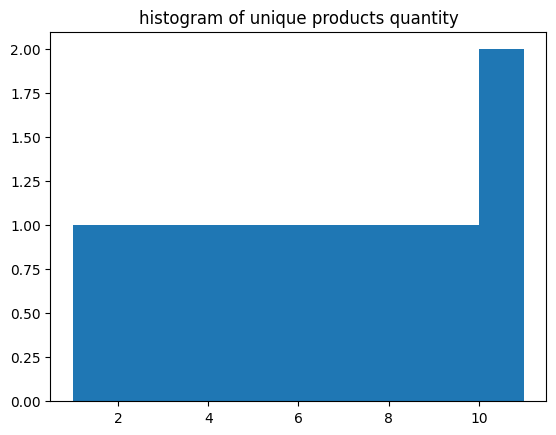

In [69]:
import matplotlib.pyplot as plt

plt.hist(final_df['quantity'].unique())
plt.title(r'histogram of unique products quantity')
plt.show()

<font color= "red"> <h3> Encoding Categorical to Numerical

In [71]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

ord_enc = OrdinalEncoder()
final_df["payment_key"] = OrdinalEncoder().fit_transform(final_df[["payment_key"]])
final_df["coustomer_key"] = OrdinalEncoder().fit_transform(final_df[["coustomer_key"]])
#final_df["fact_unit"] = OrdinalEncoder().fit_transform(final_df[["fact_unit"]])
final_df["item_name"] = OrdinalEncoder().fit_transform(final_df[["item_name"]])
final_df["escription"] = OrdinalEncoder().fit_transform(final_df[["escription"]])
final_df["man_country"] = OrdinalEncoder().fit_transform(final_df[["man_country"]])
final_df["supplier"] = OrdinalEncoder().fit_transform(final_df[["supplier"]])
final_df["division"] = OrdinalEncoder().fit_transform(final_df[["division"]])
final_df["district"] = OrdinalEncoder().fit_transform(final_df[["district"]])
final_df["upazila"] = OrdinalEncoder().fit_transform(final_df[["upazila"]])

In [72]:
final_df= final_df.drop(columns=['date', 'hour', 'day', 'quarter', 'year'])

In [73]:
final_df= final_df.drop(columns=['week'])

In [74]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   payment_key    1000000 non-null  float64
 1   coustomer_key  1000000 non-null  float64
 2   quantity       1000000 non-null  int64  
 3   total_price    1000000 non-null  float64
 4   item_name      1000000 non-null  float64
 5   escription     1000000 non-null  float64
 6   man_country    1000000 non-null  float64
 7   supplier       1000000 non-null  float64
 8   month          1000000 non-null  float64
 9   division       1000000 non-null  float64
 10  district       1000000 non-null  float64
 11  upazila        1000000 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 91.6 MB


<font color= "blue"> <h1> <b> Finding correlation using pearson correlation

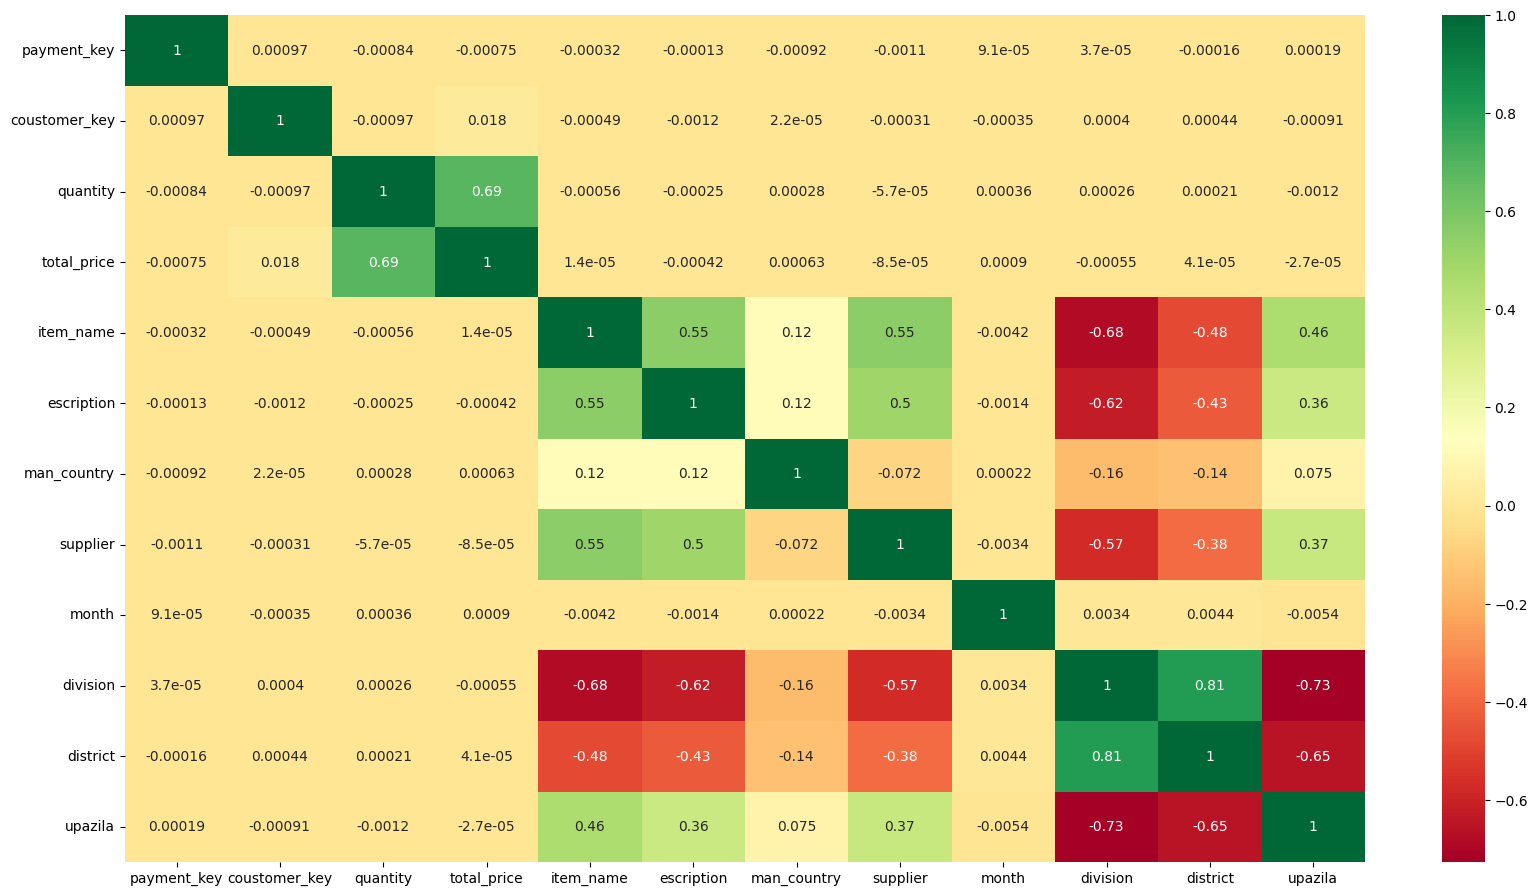

<Figure size 640x480 with 0 Axes>

In [75]:
plt.subplots(figsize=(20,11))
heat_plot = sns.heatmap(final_df.corr(method='pearson'),annot=True, cmap= "RdYlGn")
plt.figure()
plt.show()

In [77]:
X= final_df.drop(columns=['quantity'])
y= final_df['quantity']

In [78]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Scaled_X= scaler.fit_transform(X)


In [79]:
Scaled_X

array([[0.65789474, 0.66920152, 0.04841402, ..., 1.        , 0.31746032,
        0.00927644],
       [0.55263158, 0.9391635 , 0.03338898, ..., 1.        , 0.31746032,
        0.05751391],
       [0.76315789, 0.73764259, 0.15692821, ..., 1.        , 0.31746032,
        0.08534323],
       ...,
       [0.89473684, 0.4486692 , 0.60934891, ..., 0.        , 0.04761905,
        0.99443414],
       [0.78947368, 0.97338403, 0.06010017, ..., 0.        , 0.04761905,
        0.99443414],
       [0.81578947, 0.1634981 , 0.12353923, ..., 0.        , 0.04761905,
        0.99443414]])

<font color = "red"> <h1> Splitting dataset

In [81]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Scaled_X,y ,
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)

<font color= "red"> <h1> <b> Random Forest

In [82]:
from sklearn.ensemble import RandomForestRegressor

In [83]:
forest_model= RandomForestRegressor()

In [84]:
forest_model.fit(X_train, y_train)

RandomForestRegressor()

In [85]:
forest_prediction= forest_model.predict(X_test)

In [88]:
len(forest_prediction)

200000

In [89]:
len(y_test)

200000

In [91]:
prediction_count=[]

for i in range(len(y_test)):
    prediction_count.append(i)

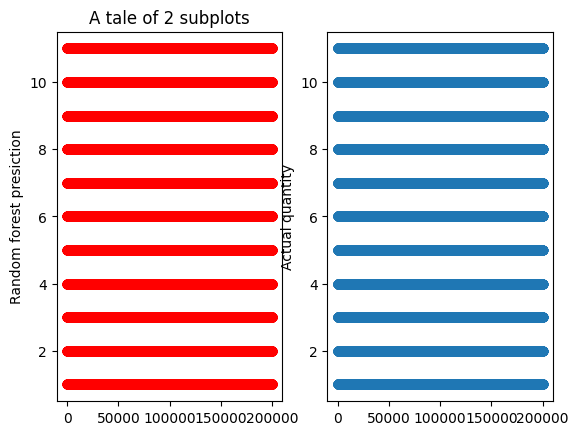

In [101]:
plt.subplot(1, 2, 1)
plt.scatter(prediction_count, forest_prediction, label="prediction", c='r')
plt.title('A tale of 2 subplots')
plt.ylabel('Random forest presiction')


plt.subplot(1, 2, 2)
plt.scatter(prediction_count, y_test, label = "actual")
plt.ylabel('Actual quantity')

plt.show()

<font color= "red"> <h1> <b> Prediction preformance

In [96]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
u
R2_forest= r2_score(y_test, forest_prediction)
print("R2 score of Random forest regression: ", R2_forest)

mse_forest= mean_squared_error(y_test, forest_prediction)
print("mse of Random forest regression: ", mse_forest)

mae_forest= mean_absolute_error(y_test, forest_prediction)
print("mae of Random Forest regression: ", mae_forest)

R2 score of Random forest regression:  1.0
mse of Random forest regression:  0.0
mae of Random Forest regression:  0.0


<font color= "red"> <h1> Forecasting Sales for 30 days

In [205]:
new_df = df_time_dim

In [208]:
n_future= 30
train_dates = pd.to_datetime(new_df['date'])

In [209]:
sorted_train_date = train_dates.sort_values(ascending= True)

In [210]:
list(sorted_train_date)[-1]

Timestamp('2021-12-01 22:58:00+0600', tz='UTC+06:00')

In [211]:
forecast_preiod_dates_Random_forest = pd.date_range(list(sorted_train_date)[-1], periods= n_future, freq= '1d' ).tolist()

In [212]:
forecast_preiod_dates_Random_forest

[Timestamp('2021-12-01 22:58:00+0600', tz='UTC+06:00', freq='D'),
 Timestamp('2021-12-02 22:58:00+0600', tz='UTC+06:00', freq='D'),
 Timestamp('2021-12-03 22:58:00+0600', tz='UTC+06:00', freq='D'),
 Timestamp('2021-12-04 22:58:00+0600', tz='UTC+06:00', freq='D'),
 Timestamp('2021-12-05 22:58:00+0600', tz='UTC+06:00', freq='D'),
 Timestamp('2021-12-06 22:58:00+0600', tz='UTC+06:00', freq='D'),
 Timestamp('2021-12-07 22:58:00+0600', tz='UTC+06:00', freq='D'),
 Timestamp('2021-12-08 22:58:00+0600', tz='UTC+06:00', freq='D'),
 Timestamp('2021-12-09 22:58:00+0600', tz='UTC+06:00', freq='D'),
 Timestamp('2021-12-10 22:58:00+0600', tz='UTC+06:00', freq='D'),
 Timestamp('2021-12-11 22:58:00+0600', tz='UTC+06:00', freq='D'),
 Timestamp('2021-12-12 22:58:00+0600', tz='UTC+06:00', freq='D'),
 Timestamp('2021-12-13 22:58:00+0600', tz='UTC+06:00', freq='D'),
 Timestamp('2021-12-14 22:58:00+0600', tz='UTC+06:00', freq='D'),
 Timestamp('2021-12-15 22:58:00+0600', tz='UTC+06:00', freq='D'),
 Timestamp

In [213]:
forecast_Random_Forest = forest_model.predict(X_test[-n_future:])

In [214]:
forecast_Random_Forest

array([ 3.,  2., 10.,  8.,  4.,  3.,  2.,  1.,  2., 11.,  8.,  1.,  8.,
        9.,  8.,  3., 10.,  2., 10.,  3.,  1.,  7.,  2.,  7.,  4., 11.,
       11.,  1.,  9.,  3.])

In [215]:
print(len(forecast_Random_Forest))

30


In [216]:
forecast_dates_Random_forest= []
for time_i in forecast_preiod_dates_Random_forest:
    forecast_dates_Random_forest.append(time_i.date())

In [217]:
forecast_dates_Random_forest

[datetime.date(2021, 12, 1),
 datetime.date(2021, 12, 2),
 datetime.date(2021, 12, 3),
 datetime.date(2021, 12, 4),
 datetime.date(2021, 12, 5),
 datetime.date(2021, 12, 6),
 datetime.date(2021, 12, 7),
 datetime.date(2021, 12, 8),
 datetime.date(2021, 12, 9),
 datetime.date(2021, 12, 10),
 datetime.date(2021, 12, 11),
 datetime.date(2021, 12, 12),
 datetime.date(2021, 12, 13),
 datetime.date(2021, 12, 14),
 datetime.date(2021, 12, 15),
 datetime.date(2021, 12, 16),
 datetime.date(2021, 12, 17),
 datetime.date(2021, 12, 18),
 datetime.date(2021, 12, 19),
 datetime.date(2021, 12, 20),
 datetime.date(2021, 12, 21),
 datetime.date(2021, 12, 22),
 datetime.date(2021, 12, 23),
 datetime.date(2021, 12, 24),
 datetime.date(2021, 12, 25),
 datetime.date(2021, 12, 26),
 datetime.date(2021, 12, 27),
 datetime.date(2021, 12, 28),
 datetime.date(2021, 12, 29),
 datetime.date(2021, 12, 30)]

In [218]:
y_last_30days= y_test[199970:200000]

In [219]:
print(len(y_last_30days))

30


In [220]:
df_forecast_Random_Forest = pd.DataFrame({'date': np.array(forecast_dates_Random_forest), 'quantity': forecast_Random_Forest})
df_forecast_Random_Forest['date']= pd.to_datetime(df_forecast_Random_Forest['date'])

<font color= "red"> <h1> Dates are not in order. Need to be in ascending order

In [221]:
final_df_copy[['date','quantity']]

,date,quantity
0,2017-05-20 14:56:00+06:00,1
1,2015-01-30 22:14:00+06:00,1
2,2020-03-14 02:34:00+06:00,8
3,2018-04-27 12:19:00+06:00,8
4,2018-04-14 10:43:00+06:00,8
...,...,...
999995,2017-08-06 08:59:00+06:00,5
999996,2017-08-06 08:59:00+06:00,1
999997,2017-08-06 08:59:00+06:00,7
999998,2017-08-06 08:59:00+06:00,2


In [222]:
original= final_df_copy[['date','quantity']]
original = original.sort_values("date")
print("after sorting :---------------------")
original

after sorting :---------------------


,date,quantity
48167,2014-01-02 00:12:00+06:00,10
70278,2014-01-02 01:04:00+06:00,8
86120,2014-01-02 01:13:00+06:00,8
28158,2014-01-02 01:31:00+06:00,8
68545,2014-01-02 01:59:00+06:00,1
...,...,...
3557,2021-12-01 18:15:00+06:00,11
92554,2021-12-01 19:38:00+06:00,5
60403,2021-12-01 20:45:00+06:00,5
76259,2021-12-01 21:07:00+06:00,3


In [223]:
#original= new_df[['date', 'month']]                                 # herer is the issue!!!
original['date']= pd.to_datetime(original['date'])
original= original.loc[original['date'] >= '2021-10-01']

In [224]:
original

,date,quantity
91116,2021-10-01 00:25:00+06:00,1
8666,2021-10-01 00:29:00+06:00,1
82591,2021-10-01 00:43:00+06:00,3
41381,2021-10-01 01:56:00+06:00,11
78271,2021-10-01 01:58:00+06:00,5
...,...,...
3557,2021-12-01 18:15:00+06:00,11
92554,2021-12-01 19:38:00+06:00,5
60403,2021-12-01 20:45:00+06:00,5
76259,2021-12-01 21:07:00+06:00,3


Text(0.5, 1.0, 'Random forest forecasted sells')

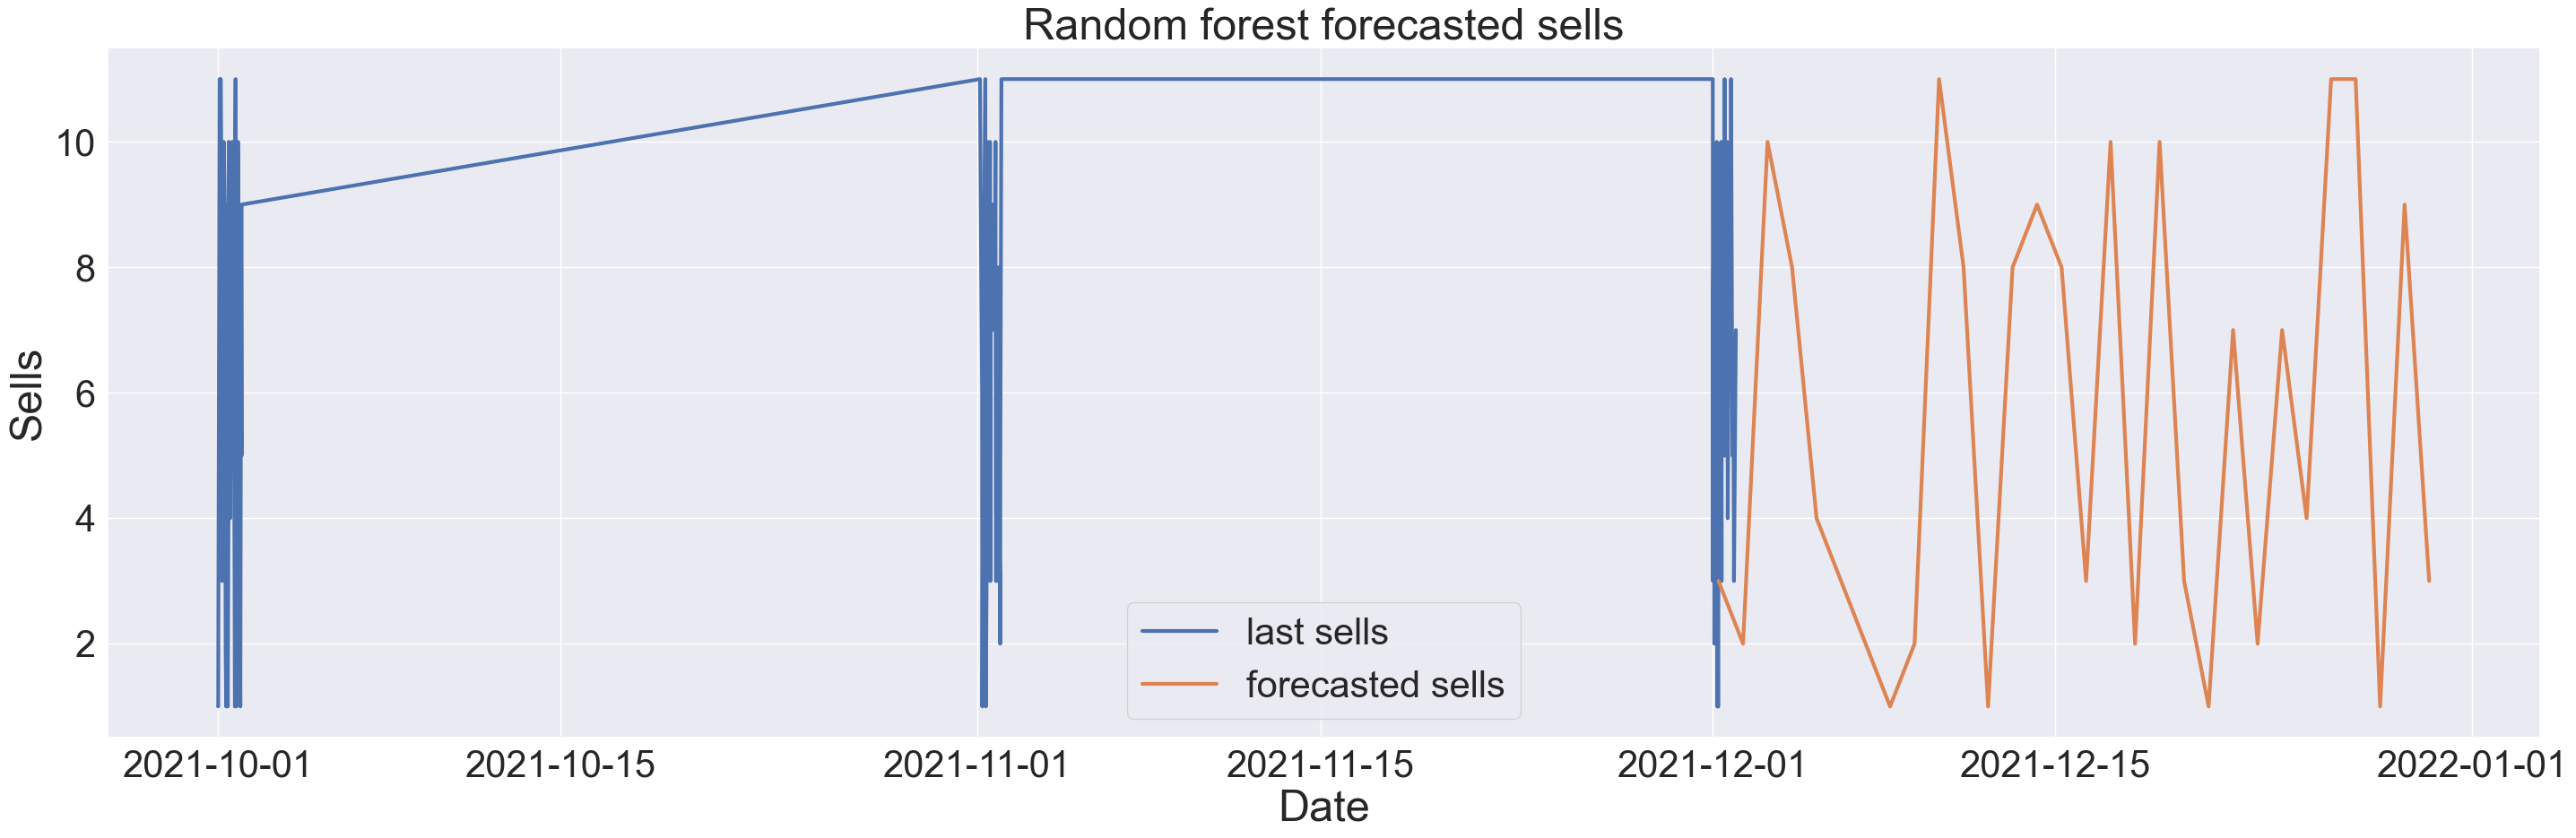

In [225]:
import seaborn as sns
sns.set(rc={"figure.figsize":(35, 10)})

plt.plot(original['date'], original['quantity'], linewidth= 3.0)
plt.plot(df_forecast_Random_Forest['date'], df_forecast_Random_Forest['quantity'], linewidth= 3.0)


plt.xlabel("Date", fontsize= 35)
plt.ylabel("Sells", fontsize= 35)

plt.yticks(fontsize=30)
plt.xticks(fontsize=30)

plt.legend(labels=["last sells ","forecasted sells"], fontsize= 30)
plt.title("Random forest forecasted sells", fontsize= 35)

<font color= "red"> <h1> Part4: </h1> </font> <font color= "blue"> <h3> 2235250650 % 5 =0 +1 =1 <br>   <font color= "lime"> (1). store and time dimensional financial analytics

In [228]:
df_store_dim

,store_key,division,district,upazila
0,S0001,SYLHET,HABIGANJ,AJMIRIGANJ
1,S0002,SYLHET,HABIGANJ,BAHUBAL
2,S0003,SYLHET,HABIGANJ,BANIACHONG
3,S0004,SYLHET,HABIGANJ,CHUNARUGHAT
4,S0005,SYLHET,HABIGANJ,HABIGANJ SADAR
...,...,...,...,...
721,S00722,BARISAL,BARISAL,HIZLA
722,S00723,BARISAL,BARISAL,BARISAL SADAR (KOTWALI)
723,S00724,BARISAL,BARISAL,MEHENDIGANJ
724,S00725,BARISAL,BARISAL,MULADI


In [229]:
df_time_dim

,time_key,date,hour,day,week,month,quarter,year
0,T00001,2017-05-20 14:56:00+06:00,14,20,3rd Week,5,Q2,2017
1,T00002,2015-01-30 22:14:00+06:00,22,30,4th Week,1,Q1,2015
2,T00003,2020-03-14 02:34:00+06:00,2,14,2nd Week,3,Q1,2020
3,T00004,2018-04-27 12:19:00+06:00,12,27,4th Week,4,Q2,2018
4,T00005,2018-04-14 10:43:00+06:00,10,14,2nd Week,4,Q2,2018
...,...,...,...,...,...,...,...,...
99994,T099995,2015-04-01 17:22:00+06:00,17,4,1st Week,1,Q1,2015
99995,T099996,2015-01-17 21:09:00+06:00,21,17,3rd Week,1,Q1,2015
99996,T099997,2020-01-23 14:42:00+06:00,14,23,4th Week,1,Q1,2020
99997,T099998,2015-10-31 13:52:00+06:00,13,31,4th Week,10,Q4,2015


<font color= "red"> <h2> <b> findings1: Which district has the most sells (quantity)

In [264]:
con = PostgresConnection().getConnection()
query = """
            SELECT  (td.division) as date, SUM(ft.quantity) as total_unit_sold
            FROM ecomdb.fact_table ft
            JOIN ecomdb.store_dim td ON ft.store_key = td.store_key
            GROUP BY td.division
            ORDER BY td.division
            """
cur = con.cursor()
cur.execute("BEGIN")
cur.execute(query)
# fetch the results
record = cur.fetchall()
# commit the transaction
con.commit()
# close the cursor
cur.close()

df = pd.DataFrame(record, columns=['division', 'Unit Sold'])
df

Successfully connected to the database


,division,Unit Sold
0,BARISAL,428042
1,CHITTAGONG,1126300
2,DHAKA,2319920
3,KHULNA,642999
4,RAJSHAHI,689138
5,RANGPUR,480244
6,SYLHET,313542


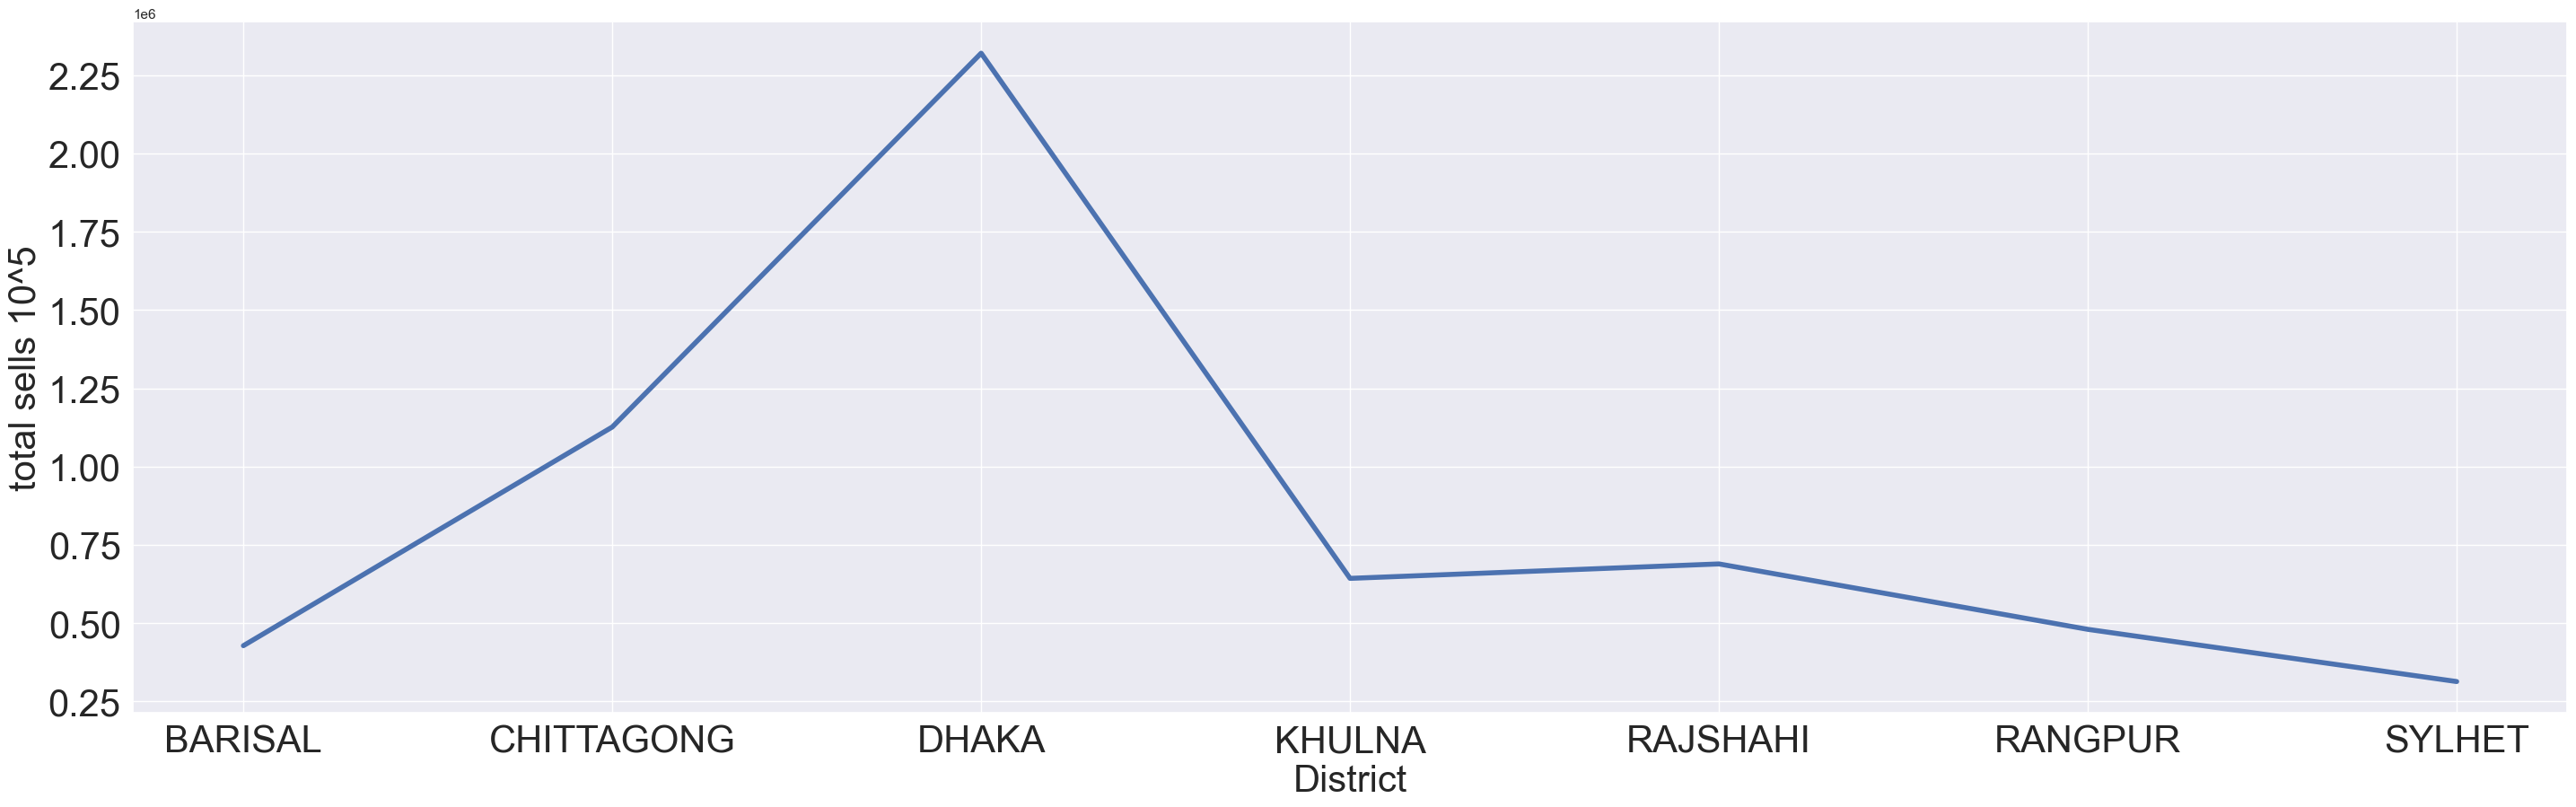

In [265]:
plt.plot(df['division'], df['Unit Sold'], linewidth= 4.0)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.xlabel("District", fontsize= 30)
plt.ylabel("total sells 10^5", fontsize= 30)
plt.show()

<font color= "red"> <h2> <b> findings2:  Sells in uapzilas

In [273]:
con = PostgresConnection().getConnection()
query = """
            SELECT  (td.upazila) as date, SUM(ft.quantity) as total_unit_sold
            FROM ecomdb.fact_table ft
            JOIN ecomdb.store_dim td ON ft.store_key = td.store_key
            GROUP BY td.upazila
            ORDER BY td.upazila
            """
cur = con.cursor()
cur.execute("BEGIN")
cur.execute(query)
# fetch the results
record = cur.fetchall()
# commit the transaction
con.commit()
# close the cursor
cur.close()

df = pd.DataFrame(record, columns=['upazila', 'Unit Sold'])
df

Successfully connected to the database


,upazila,Unit Sold
0,ABHAYNAGAR,8264
1,ADABOR,24615
2,ADAMDIGHI,8212
3,ADITMARI,8469
4,AGAILJHARA,16240
...,...,...
535,WARI,25335
536,WAZIRPUR,16827
537,ZAKIGANJ,8319
538,ZANJIRA,8360


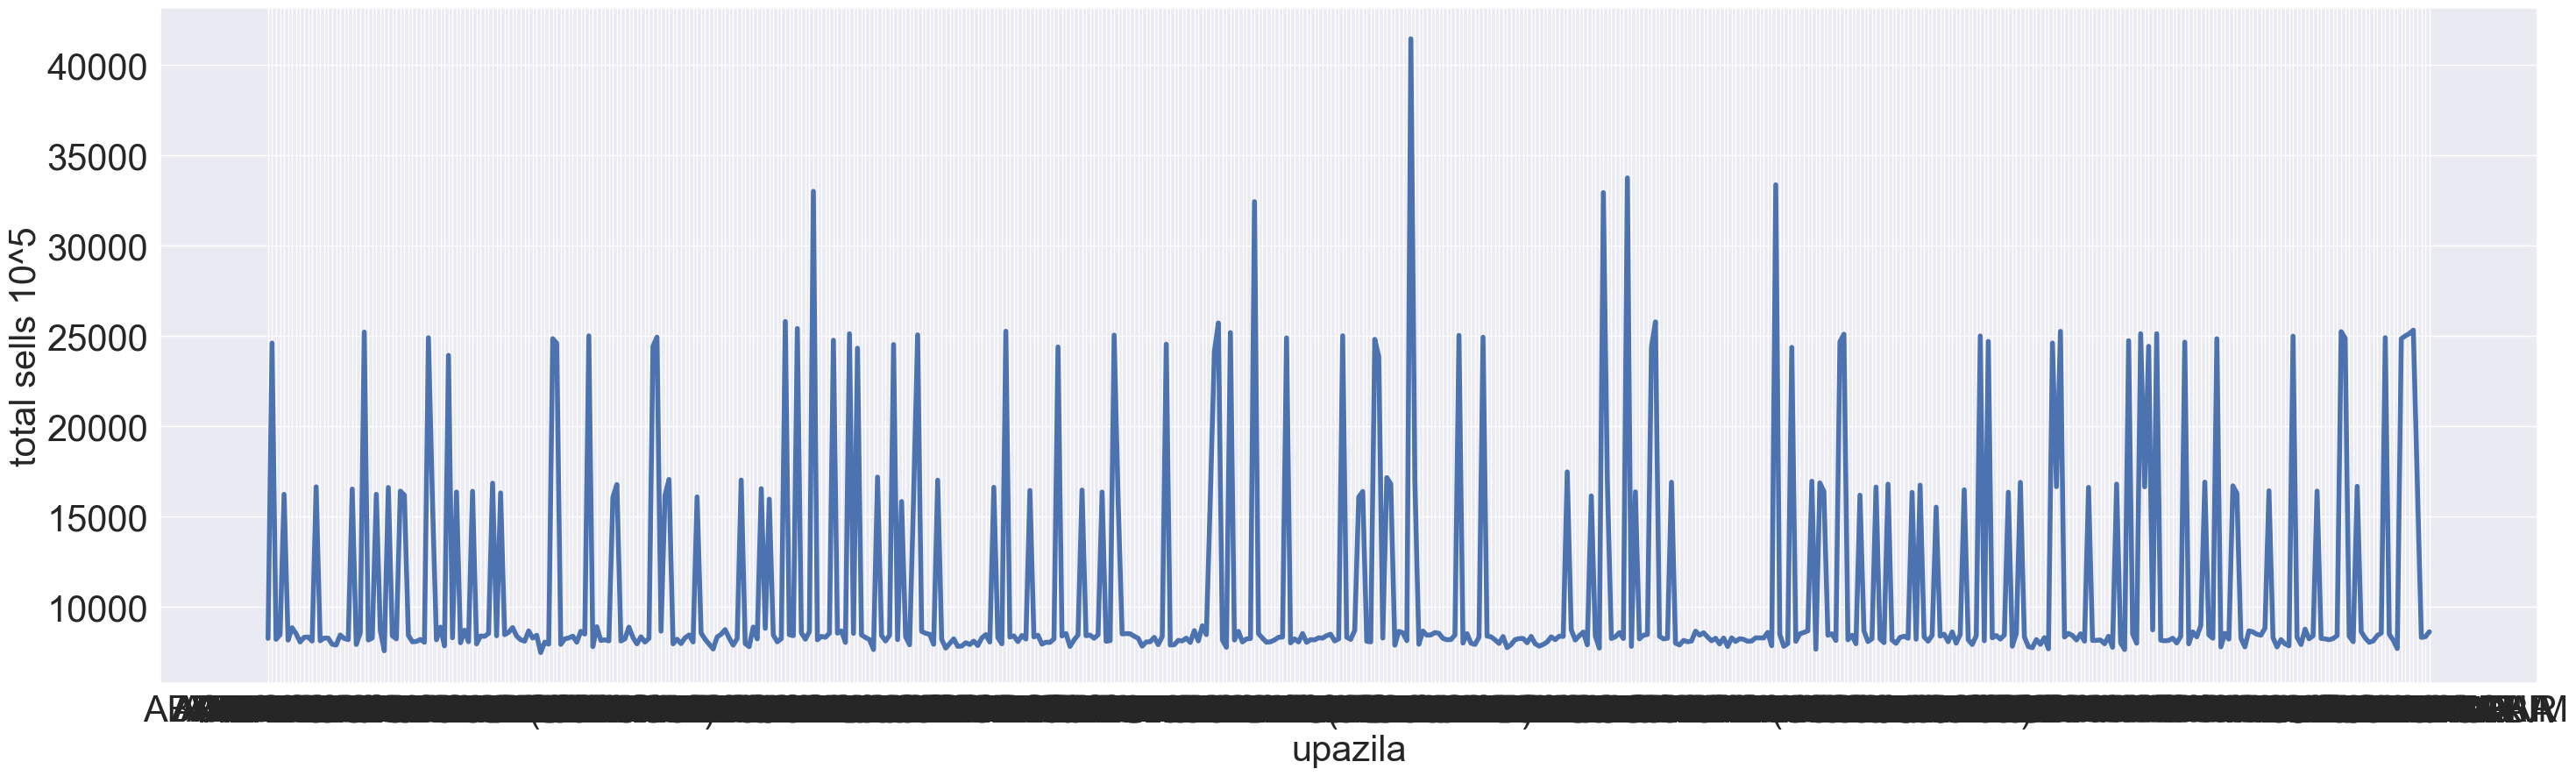

In [274]:
plt.plot(df['upazila'], df['Unit Sold'], linewidth= 4.0)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.xlabel("upazila", fontsize= 30)
plt.ylabel("total sells 10^5", fontsize= 30)
plt.show()

<font color= "red"> <h2> <b> findings3: upazilas with top most sells

In [ ]:
value= []
name= []
top_five_upazila= []
index = []

for i in df['Unit Sold']:
    value.append(i)
    
for i in df['upazila']:
    name.append(i)


for i in df['Unit Sold']:
    if(i>=30000):
        top_five_upazila.append(i)

In [291]:
top_five_upazila.sort()
top_five_upazila

for i in top_five_upazila:
    index.append(value.index(i))


In [297]:
top_upazila= []

print("Top 6 most sells uapzilas are:  ")
print("--------------------------------")
for i in index:
    top_upazila.append(name[i])
    
print(top_upazila)

Top 6 most sells uapzilas are:  
--------------------------------
['KALIGANJ', 'MIRPUR', 'DAULATPUR', 'NAWABGANJ', 'MOHAMMADPUR', 'KOTWALI']


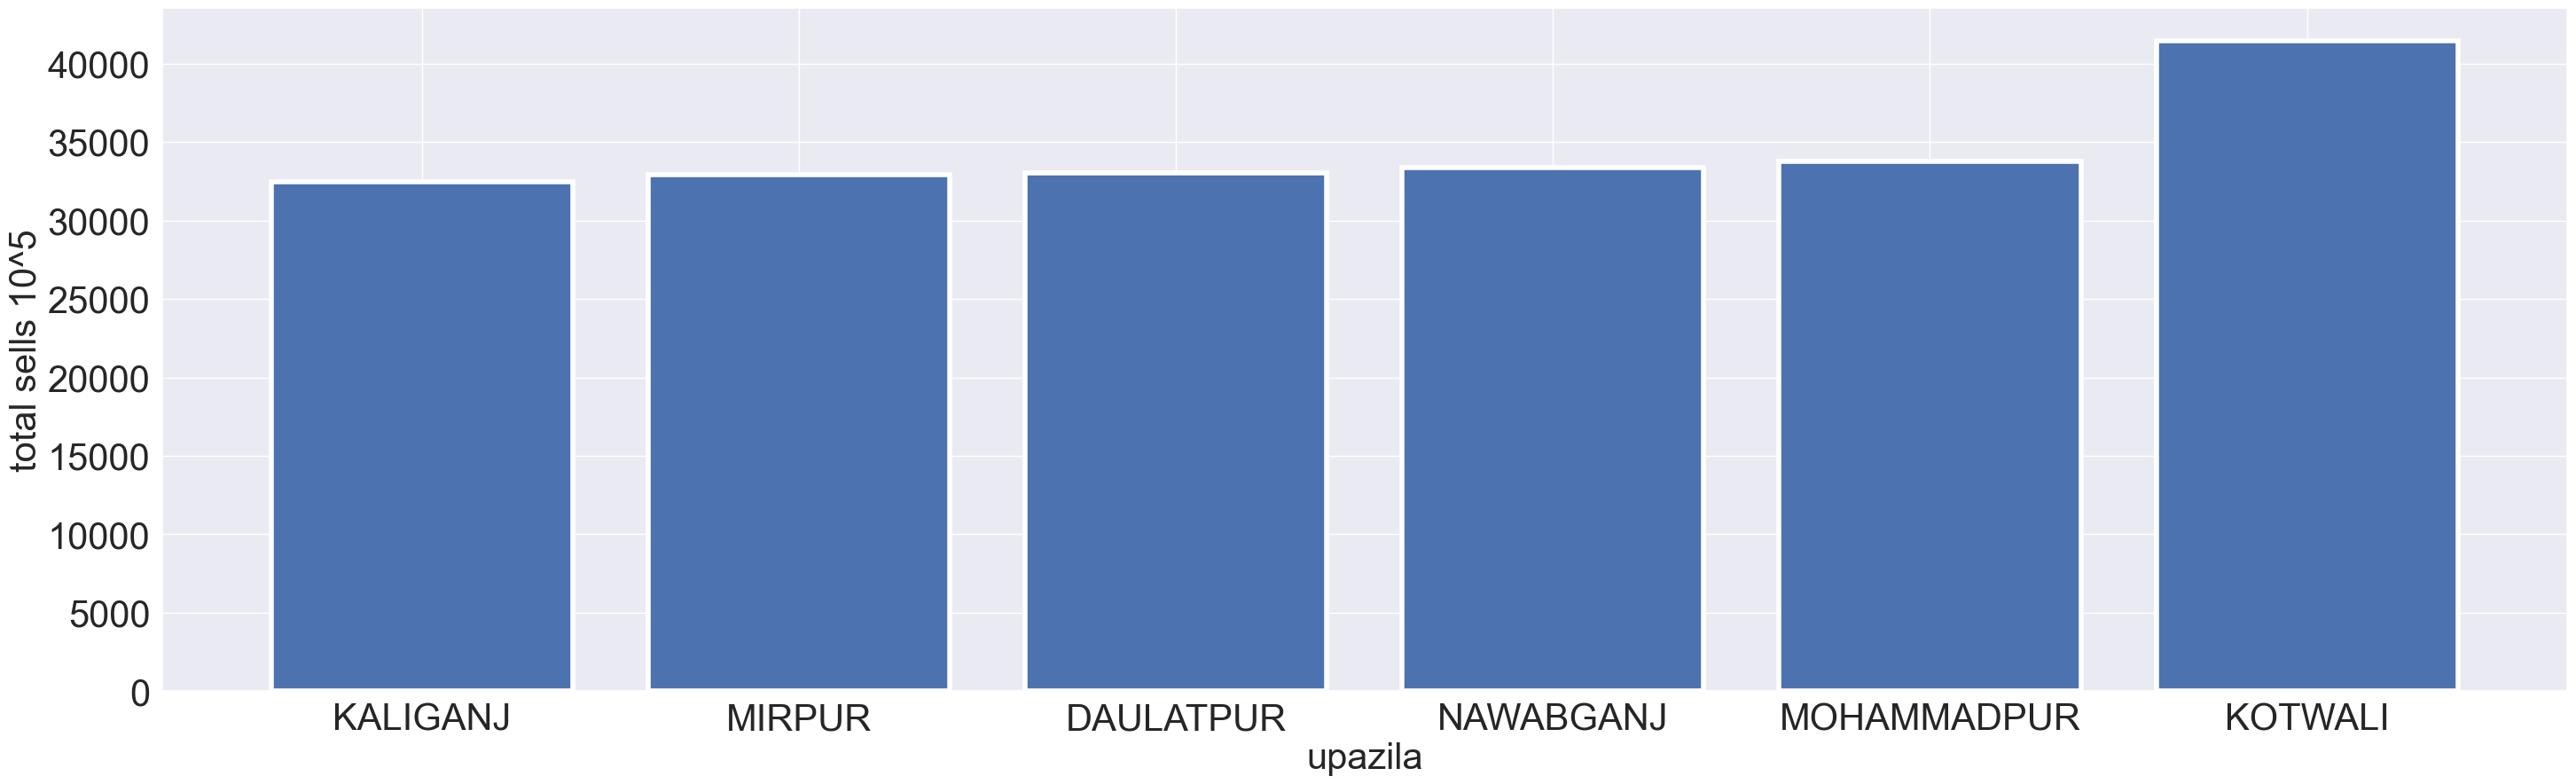

In [302]:
plt.bar(top_upazila, top_five_upazila, linewidth= 4.0)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.xlabel("upazila", fontsize= 30)
plt.ylabel("total sells", fontsize= 30)
plt.show()

<font color= "red"> <h2> <b> findings4: Which year has the most sell

In [314]:
con = PostgresConnection().getConnection()
query = """
            SELECT (td.month) as date, SUM(ft.quantity) as total_unit_sold
            FROM ecomdb.fact_table ft
            JOIN ecomdb.time_dim td ON ft.time_key = td.time_key
            GROUP BY td.month
            ORDER BY td.month
            """
cur = con.cursor()
cur.execute("BEGIN")
cur.execute(query)
# fetch the results
record = cur.fetchall()
# commit the transaction
con.commit()
# close the cursor
cur.close()
df = pd.DataFrame(record, columns=['month', 'Unit Sold'])
df

Successfully connected to the database


,year,Unit Sold
0,1,515352
1,2,459295
2,3,509009
3,4,486156
4,5,517258
5,6,485654
6,7,516339
7,8,509136
8,9,496247
9,10,507718


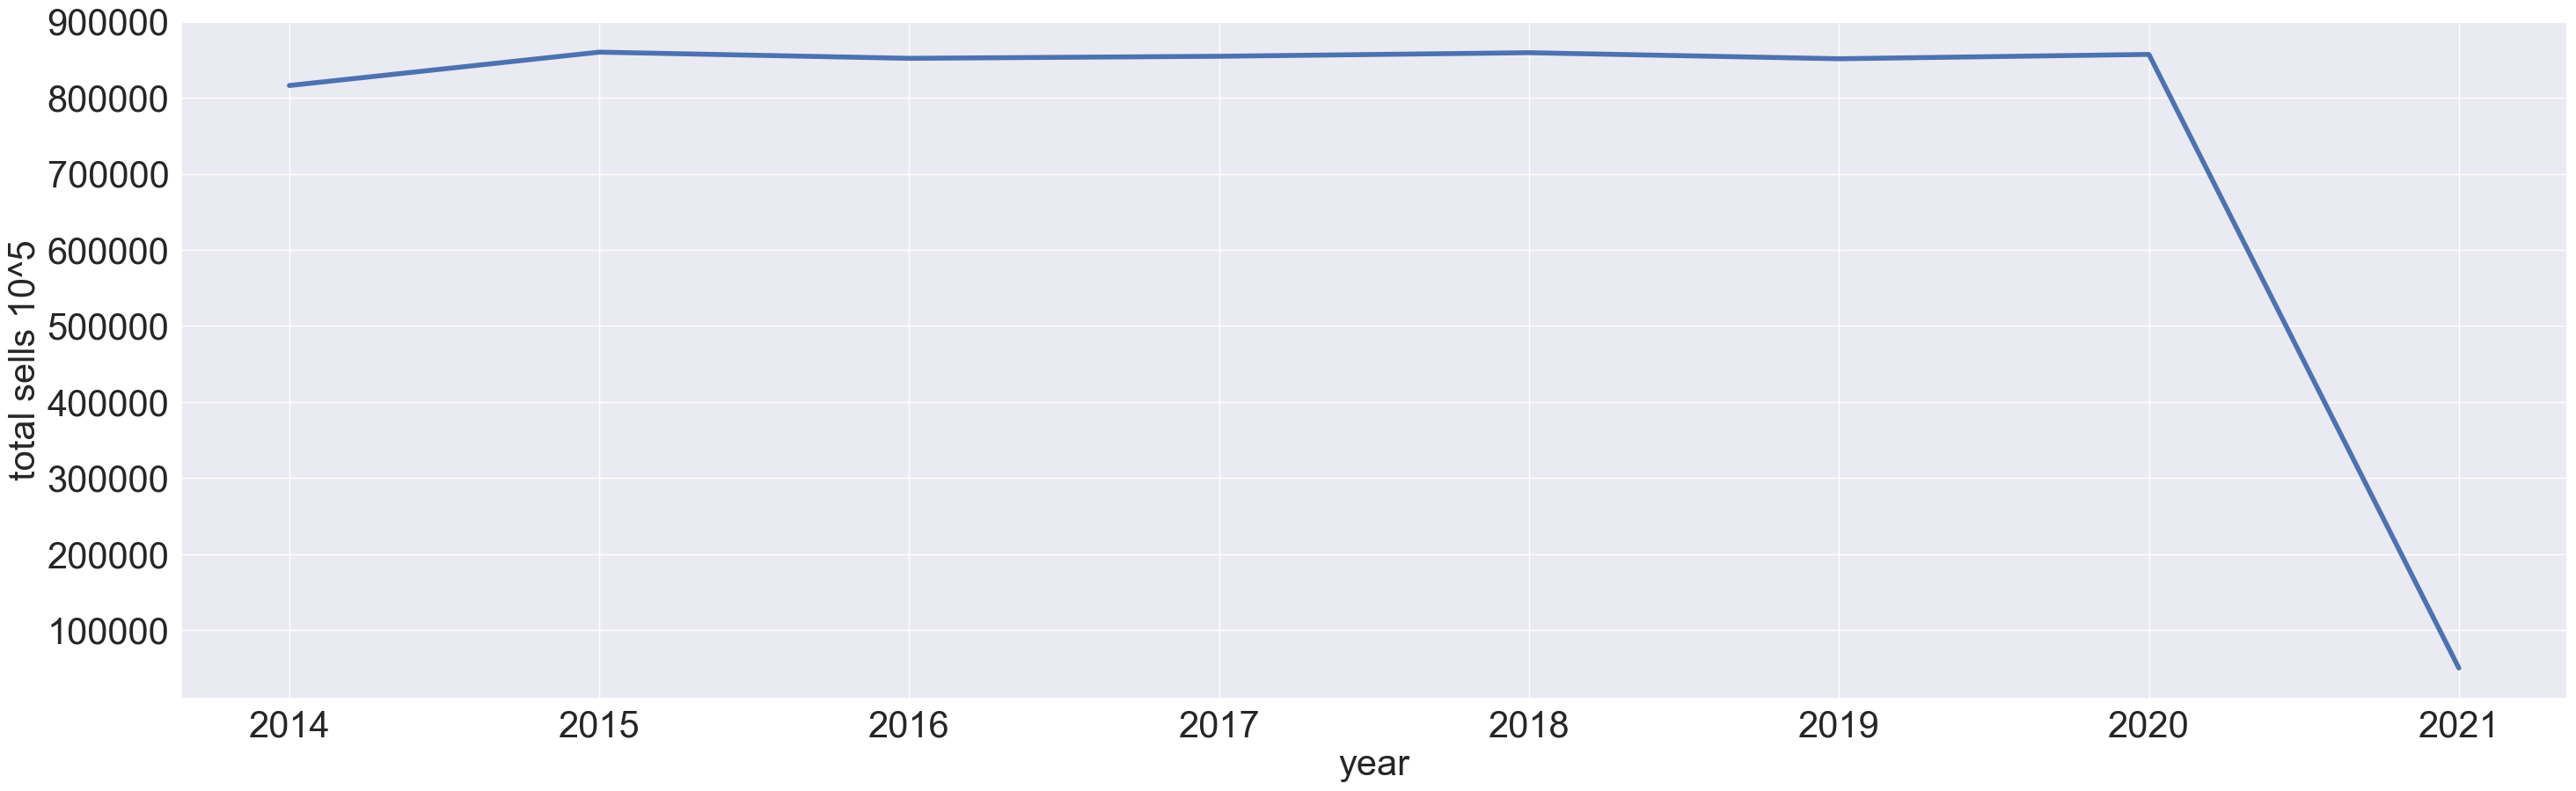

In [271]:
plt.plot(df['year'], df['Unit Sold'], linewidth= 4.0)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.xlabel("year", fontsize= 30)
plt.ylabel("total sells 10^5", fontsize= 30)
plt.show()

<font color="red"> <h2> <b> Findings5: Average sell of each district

In [304]:
con = PostgresConnection().getConnection()
query = """
            SELECT (td.division) as date, AVG(ft.quantity) as total_unit_sold
            FROM ecomdb.fact_table ft
            JOIN ecomdb.store_dim td ON ft.store_key = td.store_key
            GROUP BY td.division
            ORDER BY td.division
            """
cur = con.cursor()
cur.execute("BEGIN")
cur.execute(query)
# fetch the results
record = cur.fetchall()
# commit the transaction
con.commit()
# close the cursor
cur.close()
df = pd.DataFrame(record, columns=['division', 'Unit Sold'])
df

Successfully connected to the database


,division,Unit Sold
0,BARISAL,5.9912938805218073
1,CHITTAGONG,6.0120636276289100
2,DHAKA,5.9963607038729555
3,KHULNA,6.0001399723787839
4,RAJSHAHI,5.9885987399522051
5,RANGPUR,6.0086079623651878
6,SYLHET,6.0108122615647106


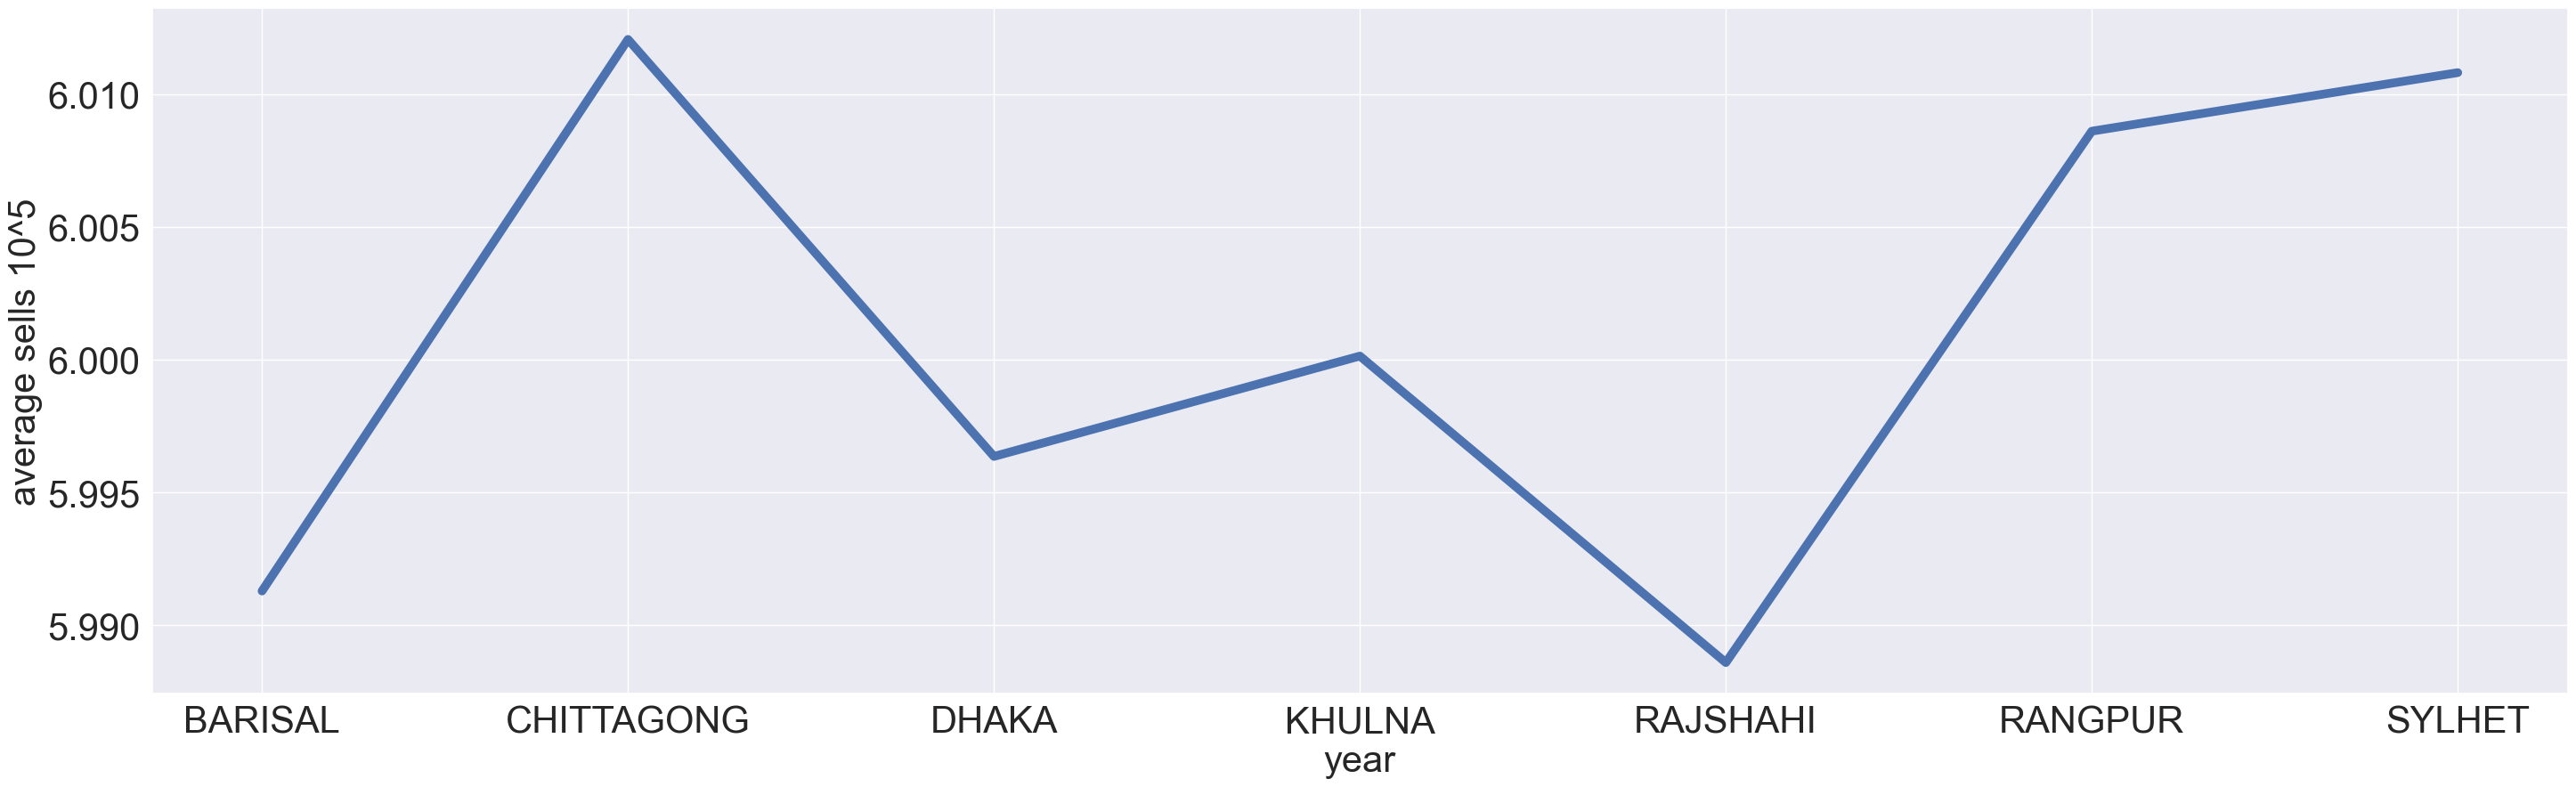

In [313]:
plt.plot(df['division'], df['Unit Sold'], linewidth= 7.0)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.xlabel("year", fontsize= 30)
plt.ylabel("average sells 10^5", fontsize= 30)
plt.show()

<font color="red"> <h2> <b> Findings5: Monthwise sell

In [318]:
con = PostgresConnection().getConnection()
query = """
            SELECT (td.month) as date, SUM(ft.quantity) as total_unit_sold
            FROM ecomdb.fact_table ft
            JOIN ecomdb.time_dim td ON ft.time_key = td.time_key
            GROUP BY td.month
            ORDER BY td.month
            """
cur = con.cursor()
cur.execute("BEGIN")
cur.execute(query)
# fetch the results
record = cur.fetchall()
# commit the transaction
con.commit()
# close the cursor
cur.close()
df = pd.DataFrame(record, columns=['month', 'Unit Sold'])
df

Successfully connected to the database


,month,Unit Sold
0,1,515352
1,2,459295
2,3,509009
3,4,486156
4,5,517258
5,6,485654
6,7,516339
7,8,509136
8,9,496247
9,10,507718


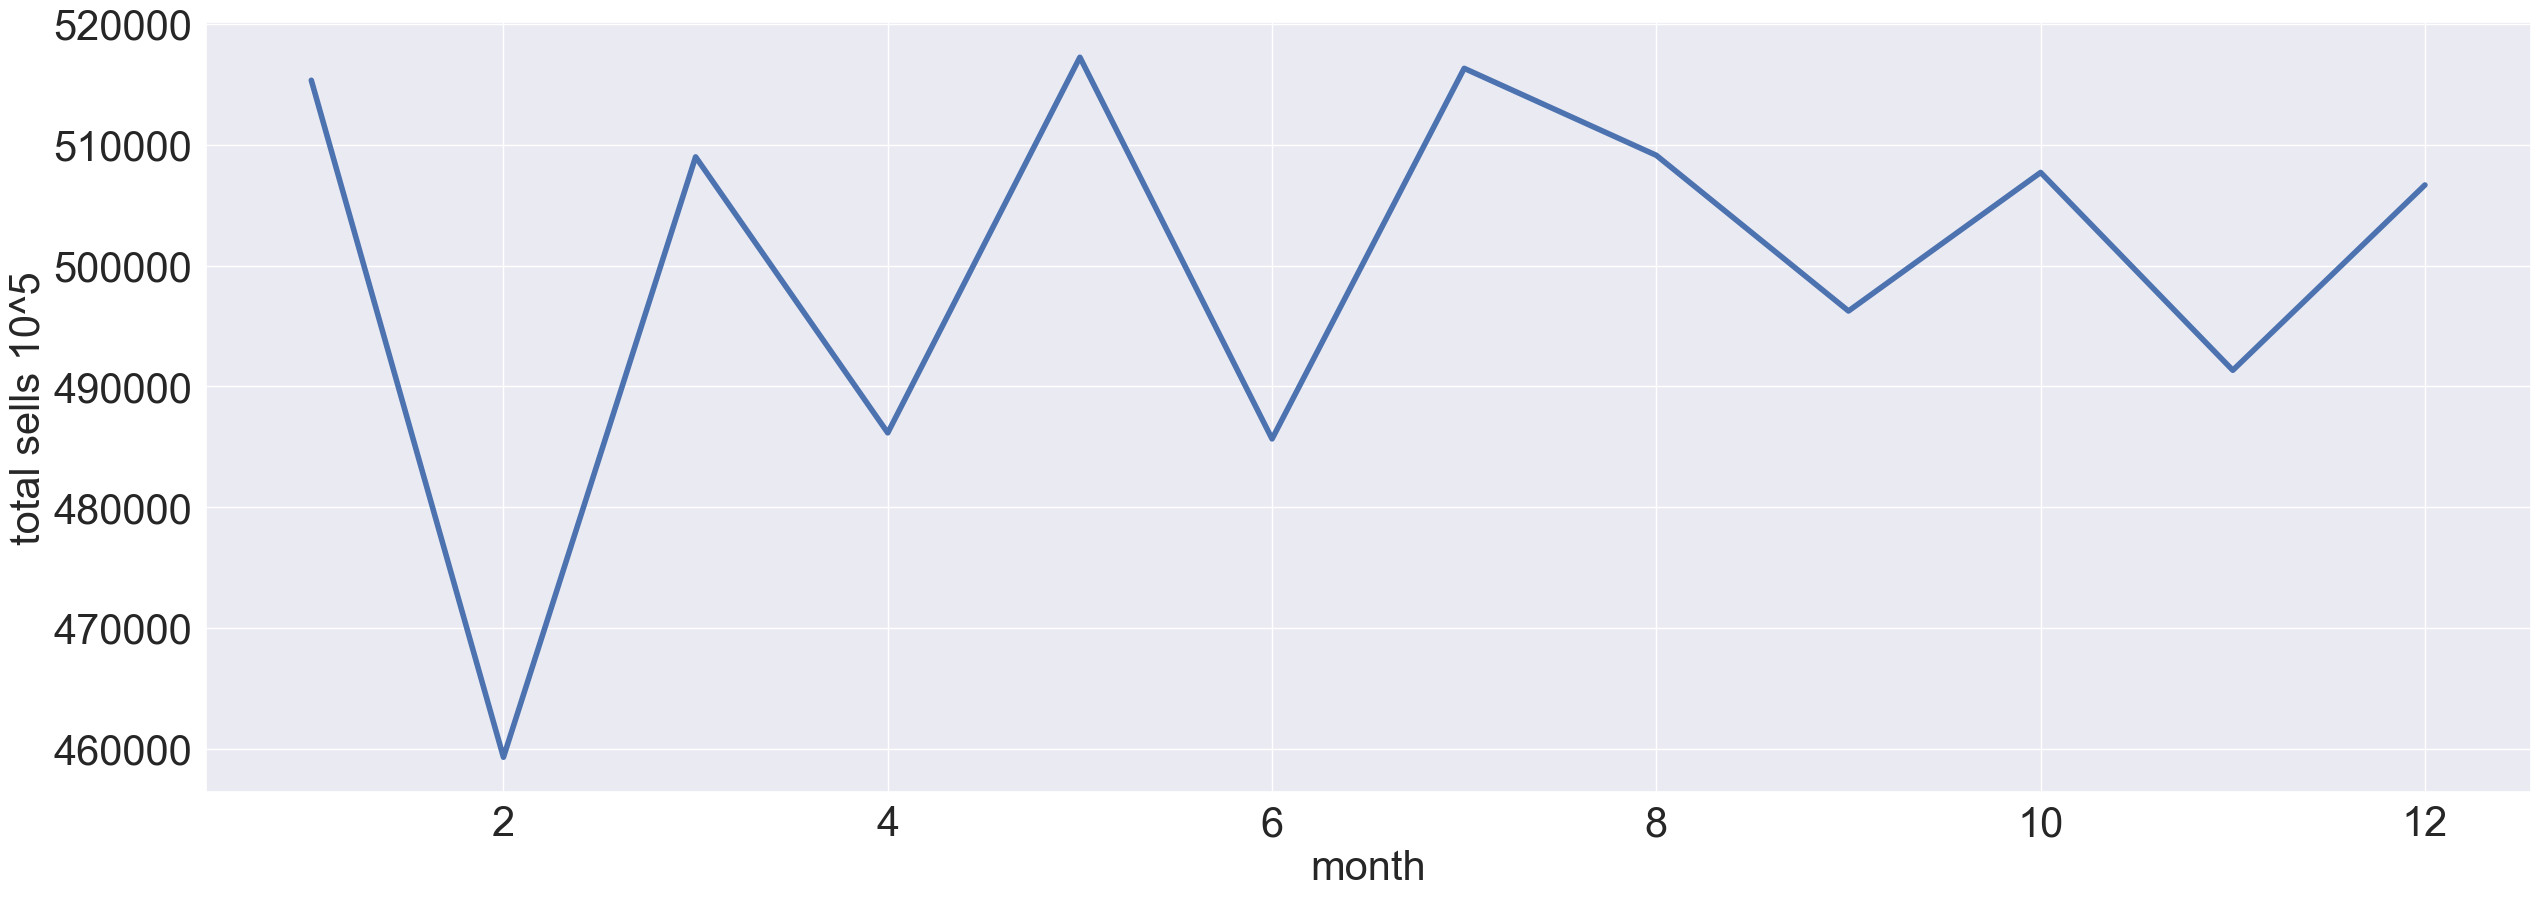

In [322]:
plt.rcParams["figure.figsize"] = (30,10)
plt.plot(df['month'], df['Unit Sold'], linewidth= 4.0)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.xlabel("month", fontsize= 30)
plt.ylabel("total sells 10^5", fontsize= 30)
plt.show()